In [6]:
import pymc3 as pm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as np  
import pandas as pd  
import seaborn as sns  
sns.set(style="darkgrid", palette="muted")  
rndst = np.random.RandomState(0)

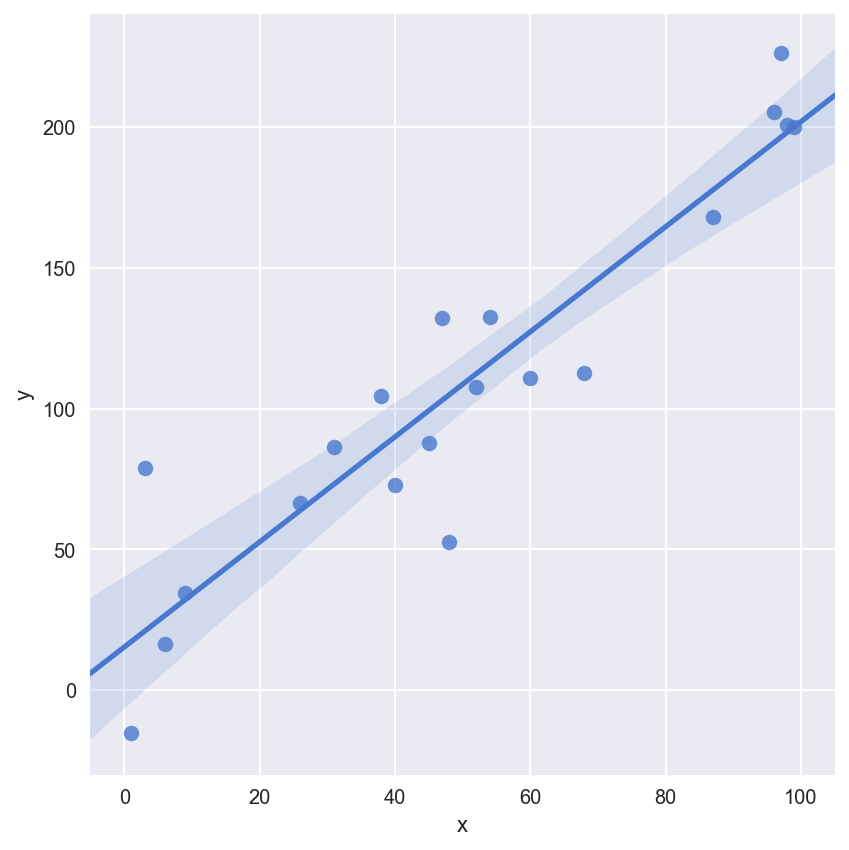

In [8]:
def generate_data(n=20, a=1, b=1, c=0, latent_error_y=10):  
    ''' 
    Create a toy dataset based on a very simple linear model 
    that we might imagine is a noisy physical process

    Model form: y ~ a + bx + cx^2 + e
    '''

    ## create linear or quadratic model
    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## add latent error noise
    df['y'] += rndst.normal(0,latent_error_y,n)

    return df

df = generate_data(a=5, b=2, latent_error_y=30)

g = sns.lmplot(x='x', y='y', data=df, fit_reg=True  
               ,size=6, scatter_kws={'alpha':0.8, 's':60})

## NOTE: `lmplot()` will fit and plot a lin. reg. line by default. 
## Not used here, but can greatly help data exploration in practice.

In [9]:
import patsy as pt  
import statsmodels.api as sm

## first, encode model specification as design matrices
fml = 'y ~ 1 + x'  
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe'
                              ,NA_action='raise')

## fit OLS model and print results
smfit = sm.OLS(endog=mx_en, exog=mx_ex, hasconst=True).fit()  
print(smfit.summary())

/Users/zhuanxu/anaconda/envs/kaggle/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     109.6
Date:                Sat, 20 Jan 2018   Prob (F-statistic):           4.40e-09
Time:                        20:22:40   Log-Likelihood:                -91.995
No. Observations:                  20   AIC:                             188.0
Df Residuals:                      18   BIC:                             190.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.3647     10.596      1.450      0.1

## 扔硬币实验

In [10]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

In [11]:
# Create a list of the number of coin tosses ("Bernoulli trials")
number_of_trials = [0, 2, 10, 20, 50, 500]

# Conduct 500 coin tosses and output into a list of 0s and 1s
# where 0 represents a tail and 1 represents a head
data = stats.bernoulli.rvs(0.5, size=number_of_trials[-1])

In [12]:
# Discretise the x-axis into 100 separate plotting points
x = np.linspace(0, 1, 100)

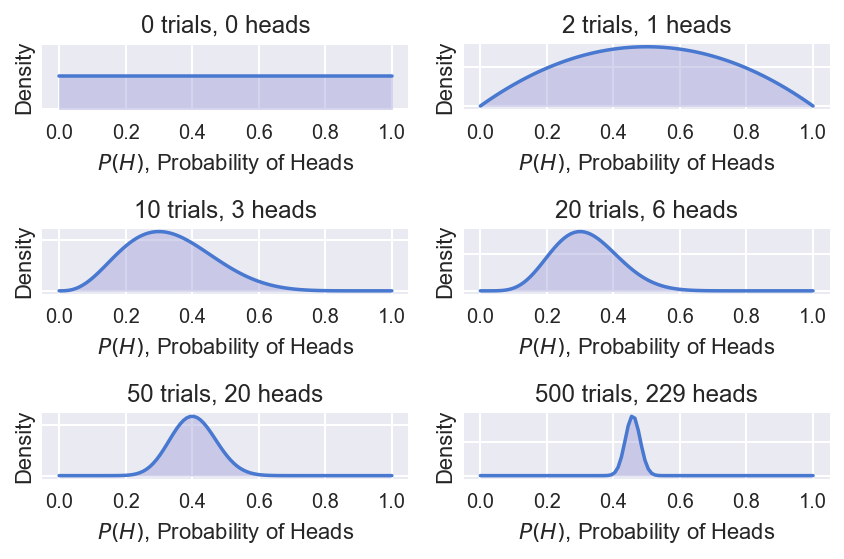

In [14]:
# Loops over the number_of_trials list to continually add
# more coin toss data. For each new set of data, we update
# our (current) prior belief to be a new posterior. This is
# carried out using what is known as the Beta-Binomial model.
# For the time being, we won't worry about this too much. It 
# will be the subject of a later article!
for i, N in enumerate(number_of_trials):
    # Accumulate the total number of heads for this 
    # particular Bayesian update
    heads = data[:N].sum()

    # Create an axes subplot for each update 
    ax = plt.subplot(len(number_of_trials) / 2, 2, i + 1)
    ax.set_title("%s trials, %s heads" % (N, heads))

    # Add labels to both axes and hide labels on y-axis
    plt.xlabel("$P(H)$, Probability of Heads")
    plt.ylabel("Density")
    if i == 0:
        plt.ylim([0.0, 2.0])
    plt.setp(ax.get_yticklabels(), visible=False)

    # Create and plot a  Beta distribution to represent the 
    # posterior belief in fairness of the coin.
    y = stats.beta.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#aaaadd", alpha=0.5)

# Expand plot to cover full width/height and show it
plt.tight_layout()
plt.show()

## Inferring a Binonial Proportion

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3
import scipy.stats as stats

plt.style.use("ggplot")

In [16]:
# Parameter values for prior and analytic posterior
n = 50
z = 10
alpha = 12
beta = 12
alpha_post = 22
beta_post = 52

# How many iterations of the Metropolis 
# algorithm to carry out for MCMC
iterations = 100000

In [17]:
# Use PyMC3 to construct a model context
basic_model = pymc3.Model()
with basic_model:
    # Define our prior belief about the fairness
    # of the coin using a Beta distribution
    theta = pymc3.Beta("theta", alpha=alpha, beta=beta)

    # Define the Bernoulli likelihood function
    y = pymc3.Binomial("y", n=n, p=theta, observed=z)

    # Carry out the MCMC analysis using the Metropolis algorithm
    # Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
    start = pymc3.find_MAP() 

    # Use the Metropolis algorithm (as opposed to NUTS or HMC, etc.)
    step = pymc3.Metropolis()

    # Calculate the trace
    trace = pymc3.sample(iterations, step, start, random_seed=1, progressbar=True)

logp = -10.252, ||grad|| = 15: 100%|██████████| 7/7 [00:00<00:00, 69.27it/s]
100%|██████████| 100500/100500 [00:14<00:00, 6906.36it/s]


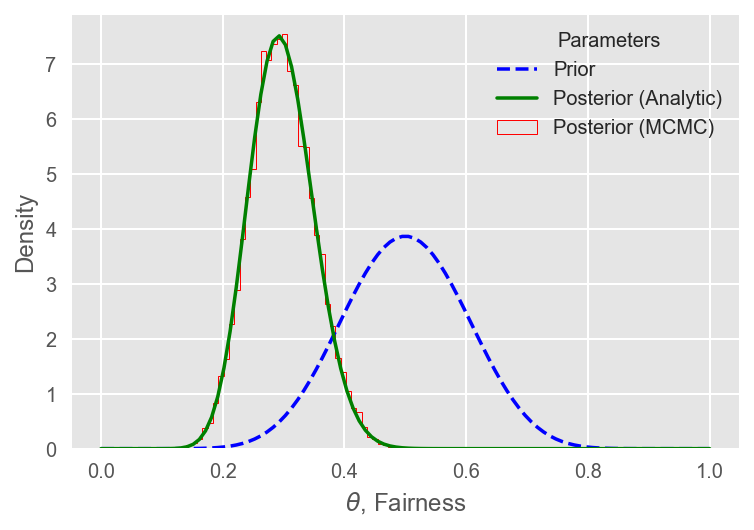

In [18]:
# Plot the posterior histogram from MCMC analysis
bins=50
plt.hist(
    trace["theta"], bins, 
    histtype="step", normed=True, 
    label="Posterior (MCMC)", color="red"
)

# Plot the analytic prior and posterior beta distributions
x = np.linspace(0, 1, 100)
plt.plot(
    x, stats.beta.pdf(x, alpha, beta), 
    "--", label="Prior", color="blue"
)
plt.plot(
    x, stats.beta.pdf(x, alpha_post, beta_post), 
    label='Posterior (Analytic)', color="green"
)

# Update the graph labels
plt.legend(title="Parameters", loc="best")
plt.xlabel("$\\theta$, Fairness")
plt.ylabel("Density")
plt.show()

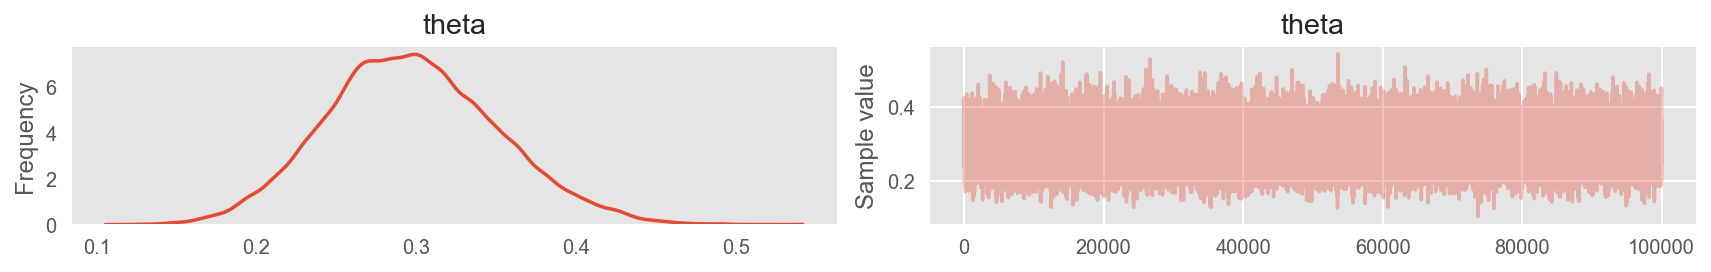

In [19]:
# Show the trace plot
pymc3.traceplot(trace)
plt.show()

一下内容来自[mcmc-sampling](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)

In [26]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [27]:
data = np.random.randn(20)# 正态分布，0，1

In [28]:
data

array([-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
        1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ,
       -0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
       -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ])

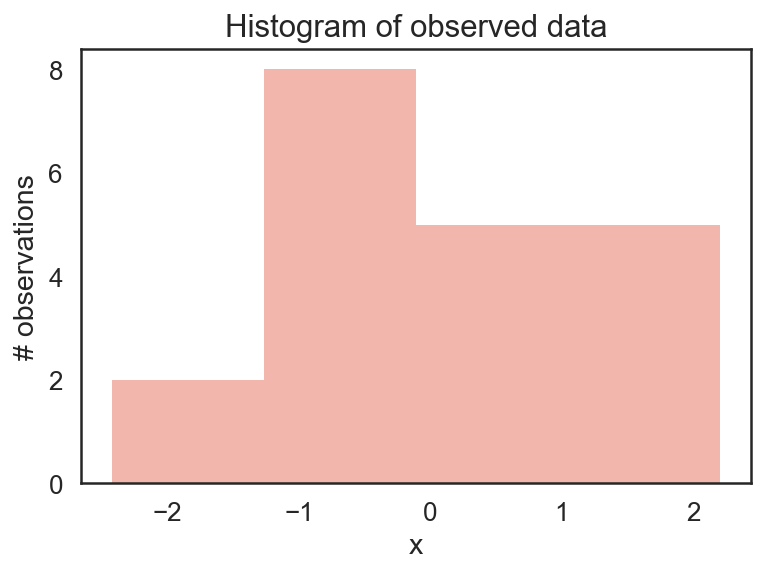

In [31]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

μ∼Normal(0,1) # 参数先验概率

x|μ∼Normal(x;μ,1) # 似然

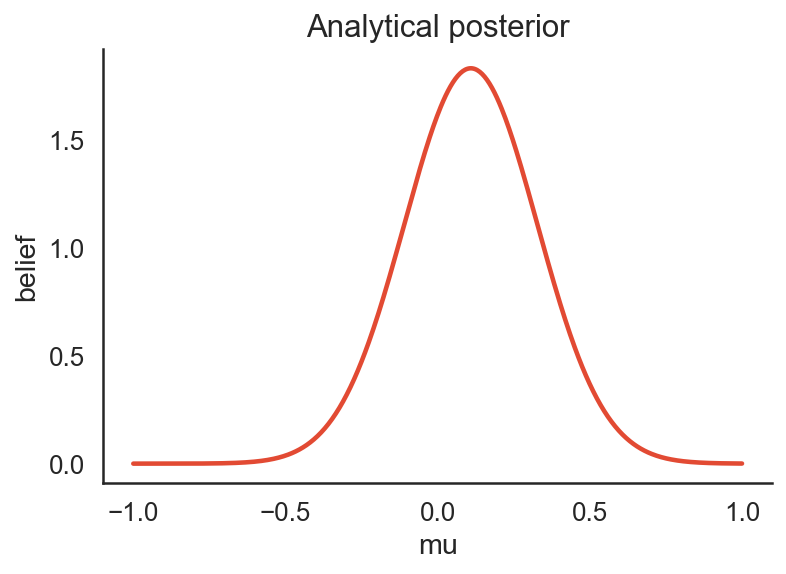

In [32]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

下面是mcmc的方法，我们从假设 μ = 1 开始

In [34]:
mu_current = 1.

In [36]:
proposal_width = 1

In [37]:
proposal = norm(mu_current, proposal_width).rvs()

In [42]:
mu_proposal= proposal

挑选出新的值后，我们下一步就是要去衡量新的参数好不好，怎么定义好不好呢？就是看新的参数是否能更好的**解释数据**。

怎么去定义**更好的解释数据呢？**

可以用下面的公式
![](http://static.zybuluo.com/zhuanxu/q1gzlifkbcc03fyxz4qe75mw/image_1c4ce1ohta5d1inlfjmkk9h3r4a.png)

解释起来就是基于当前观测数据，哪个参数概率更大

In [44]:
mu_prior_mu = 0
mu_prior_sd = 1
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

In [45]:
p_accept = p_proposal / p_current
p_accept

3.3767245410807163e-09

In [46]:
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

下面来解释下为什么上述过程起作用呢？

In [47]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

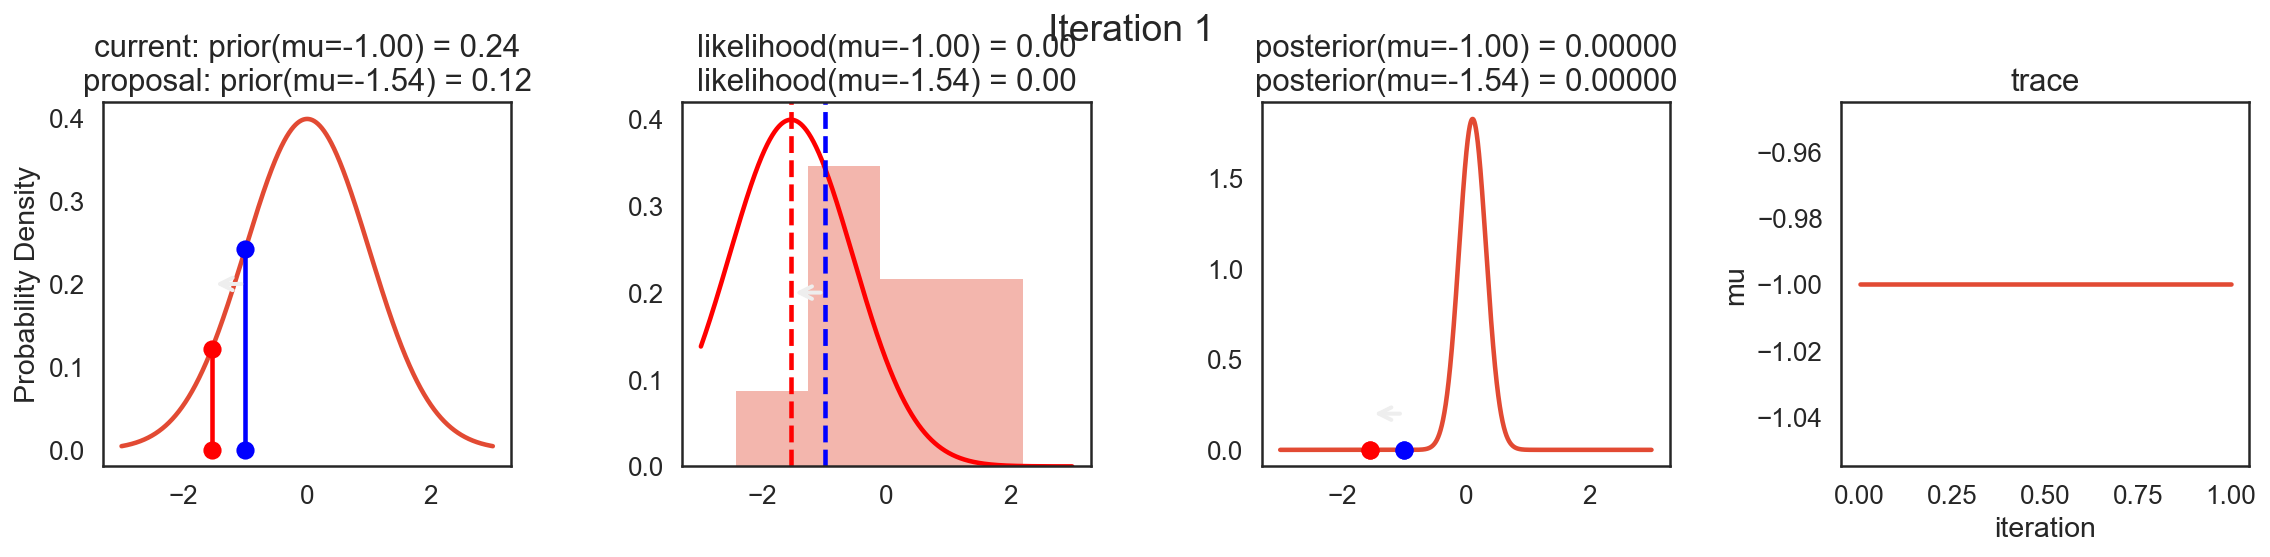

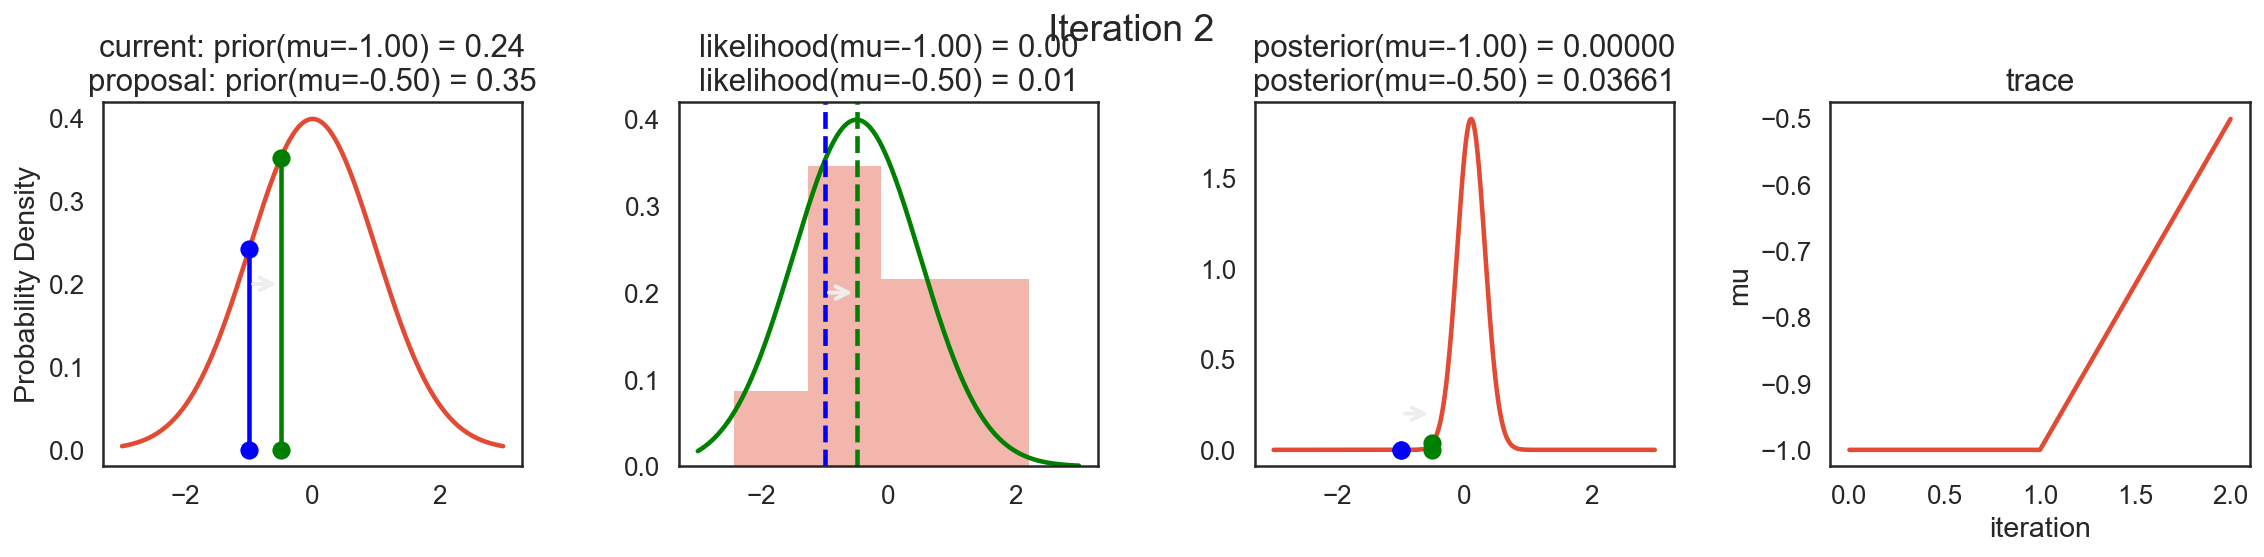

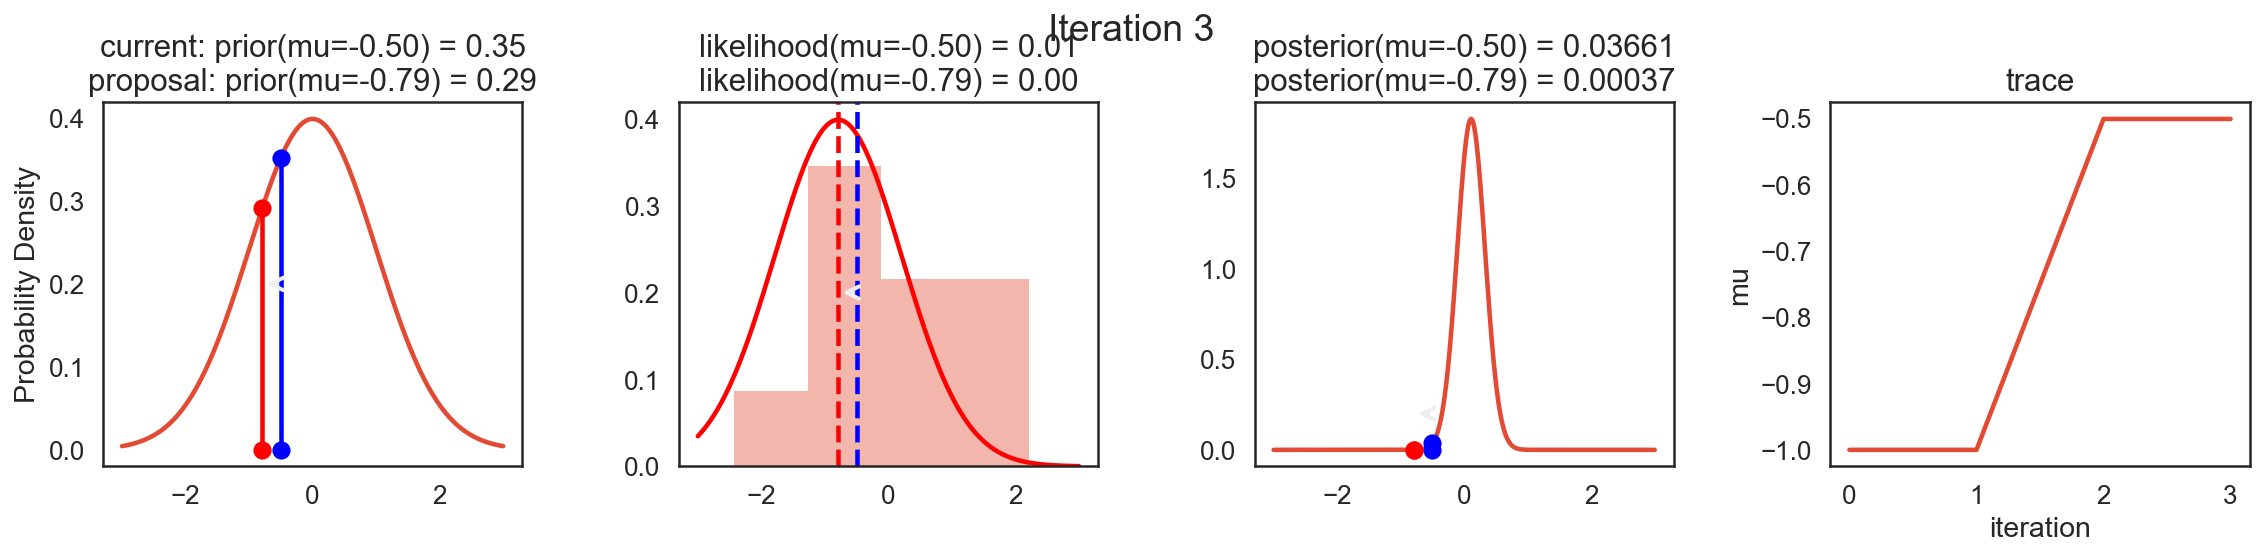

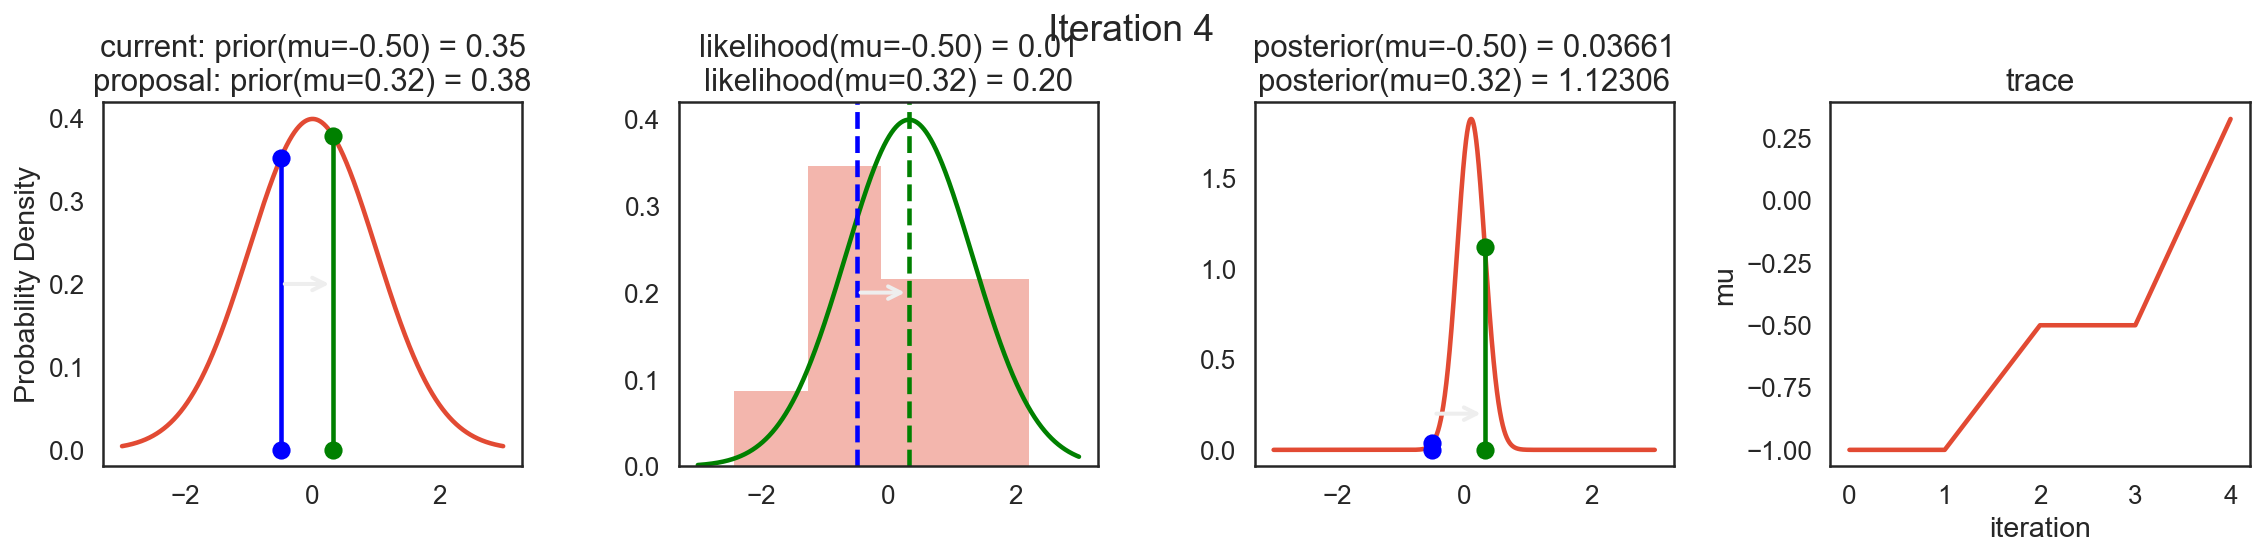

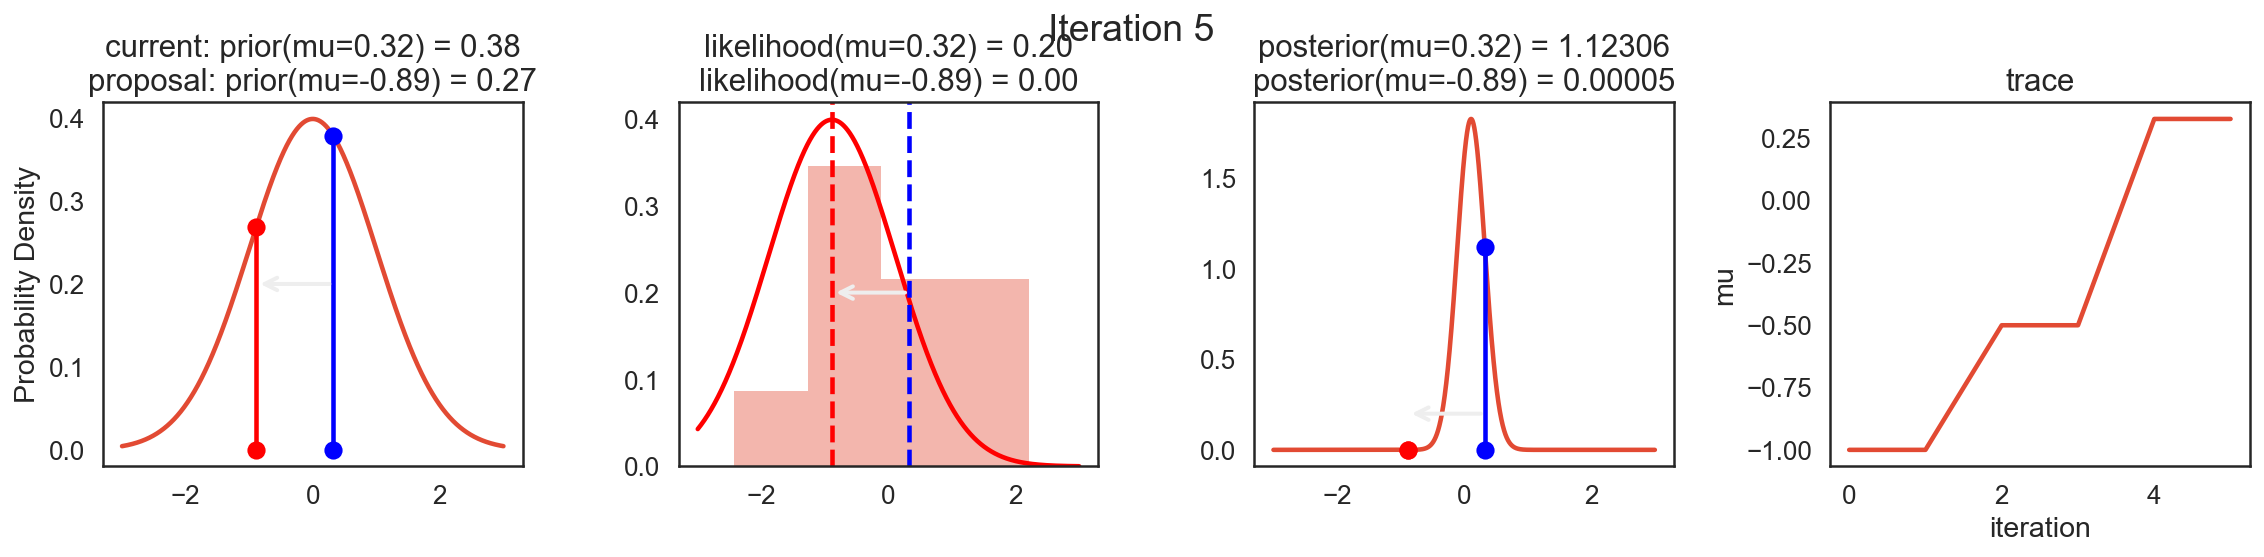

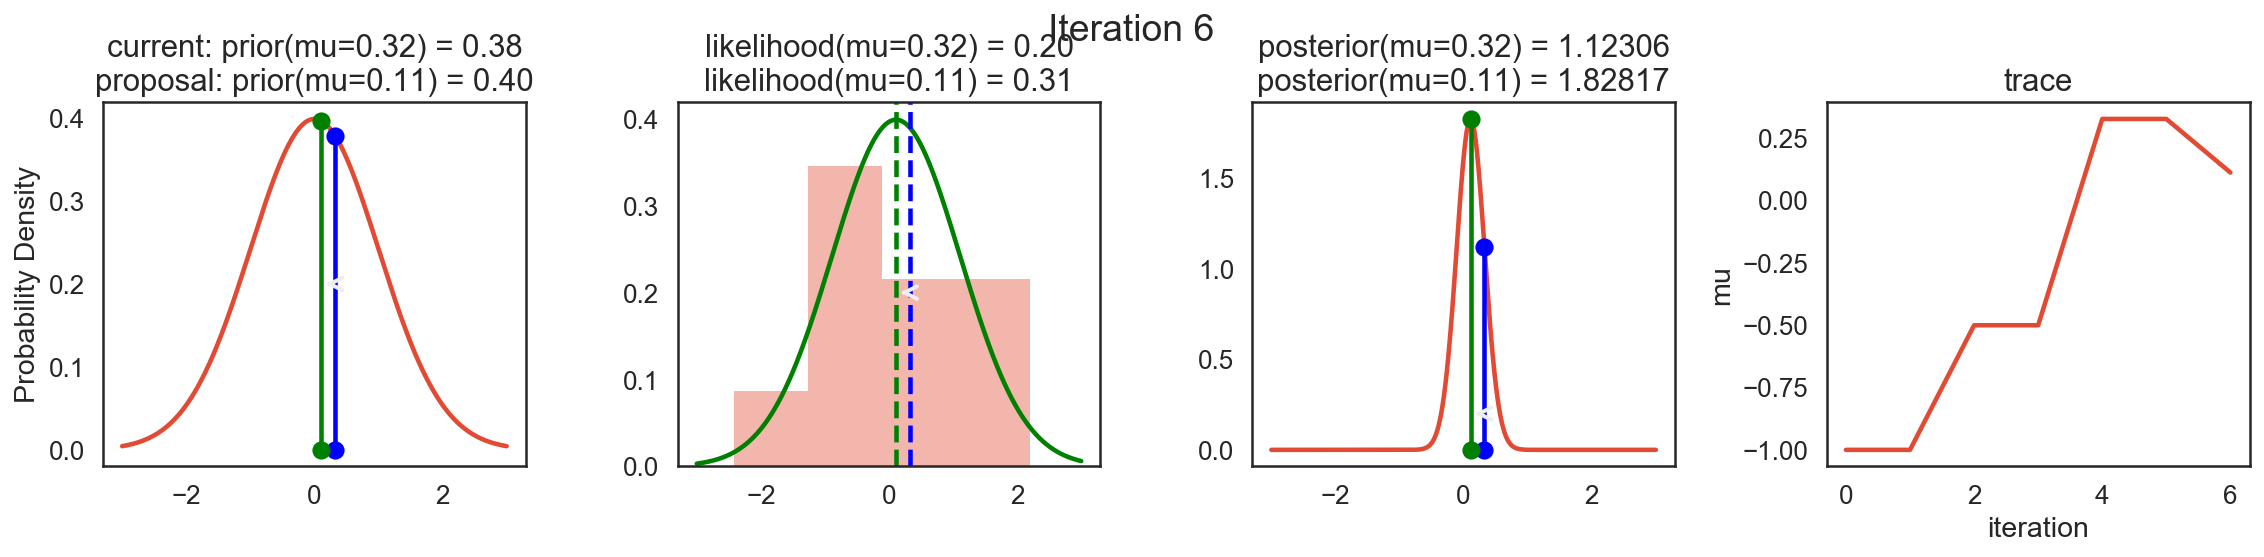

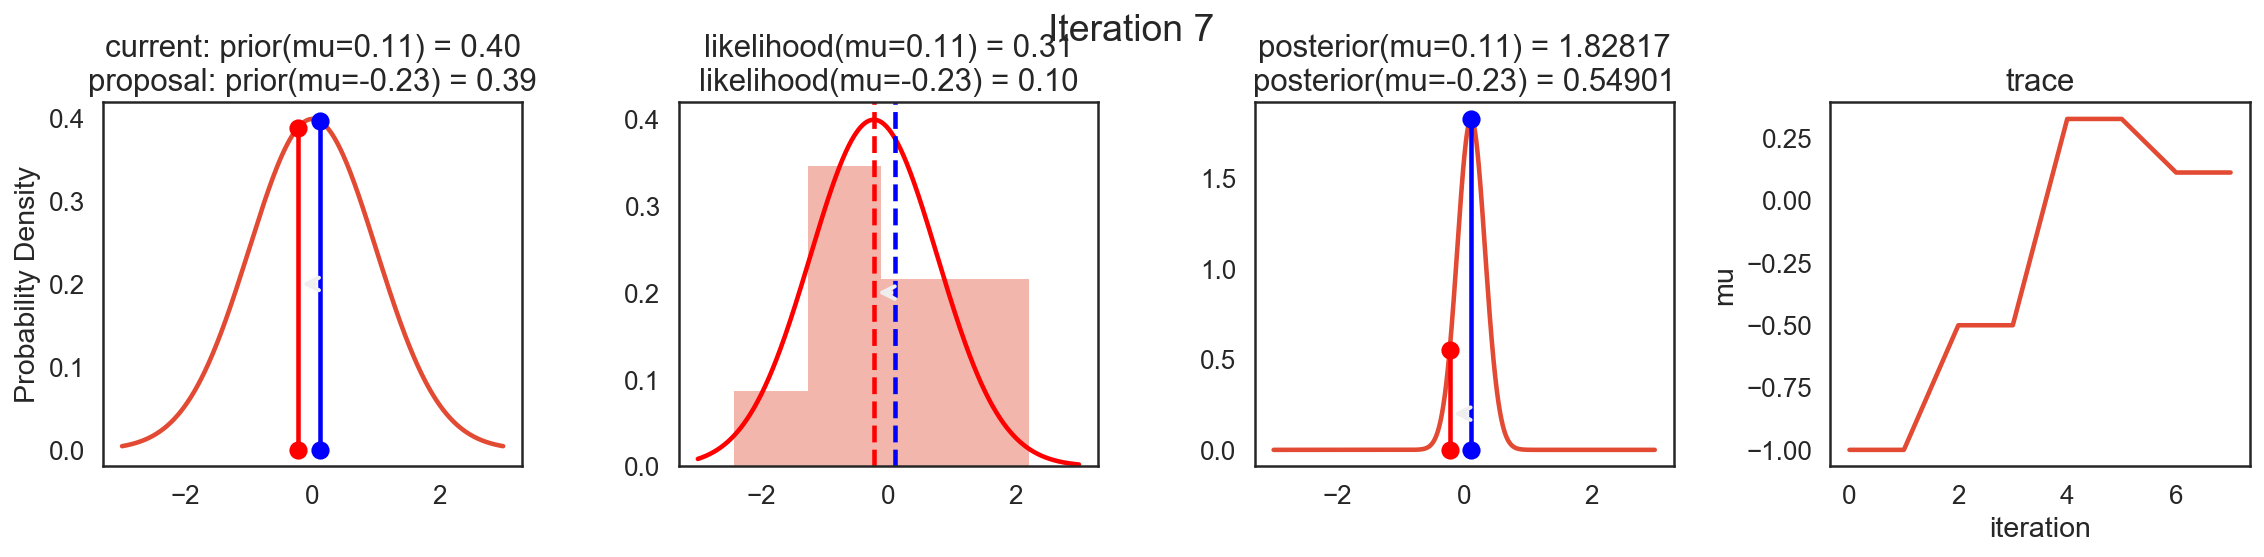

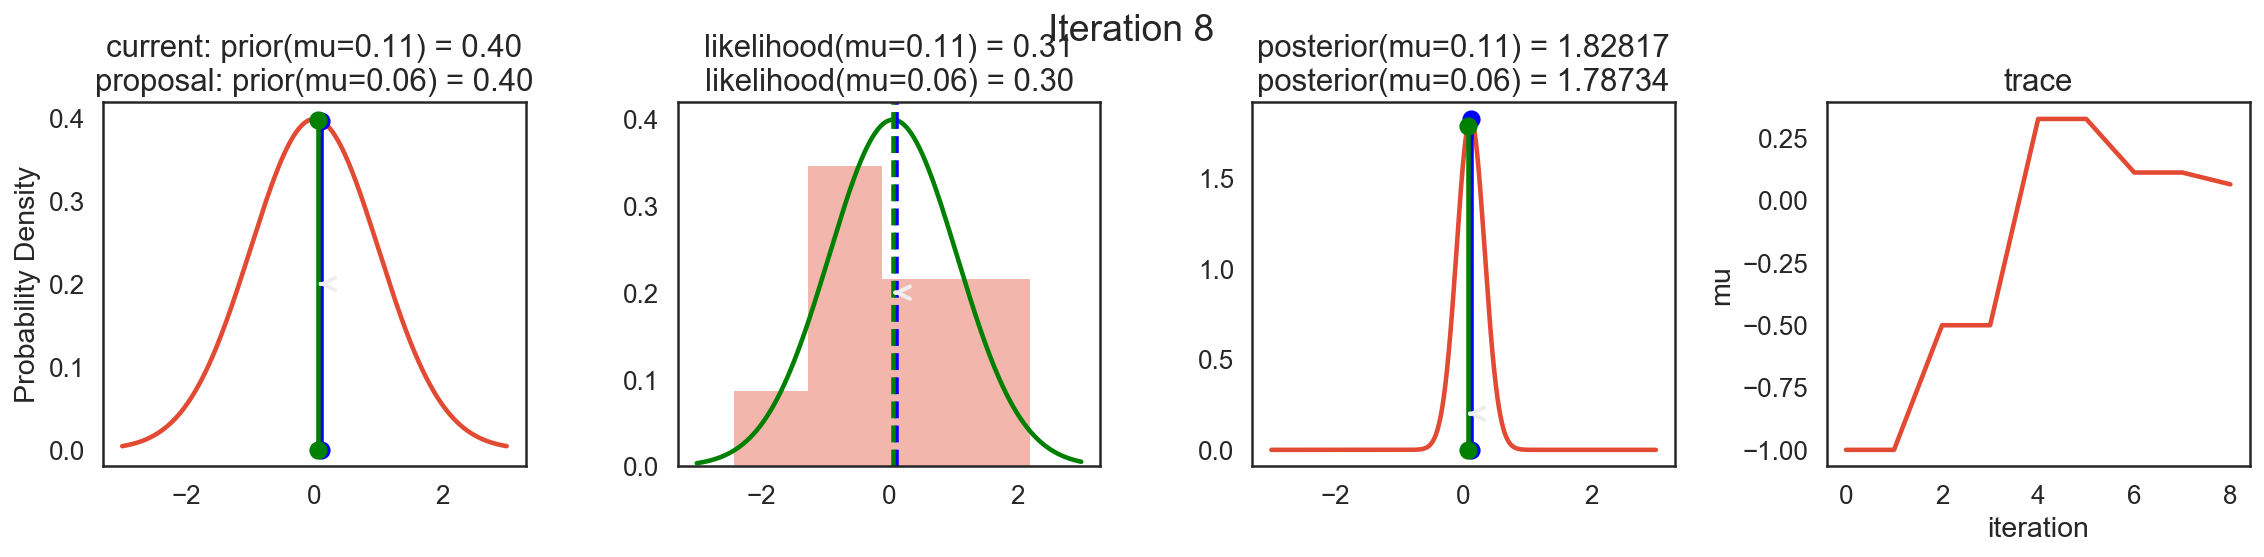

In [48]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

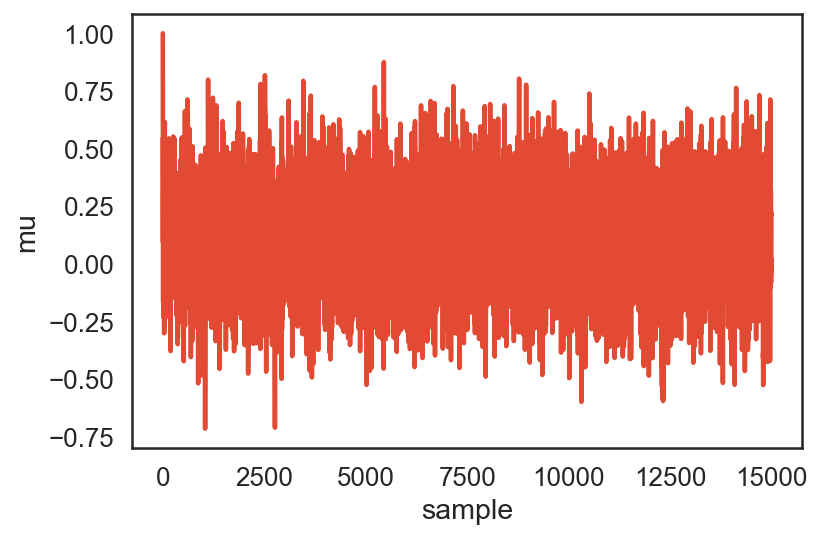

In [49]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

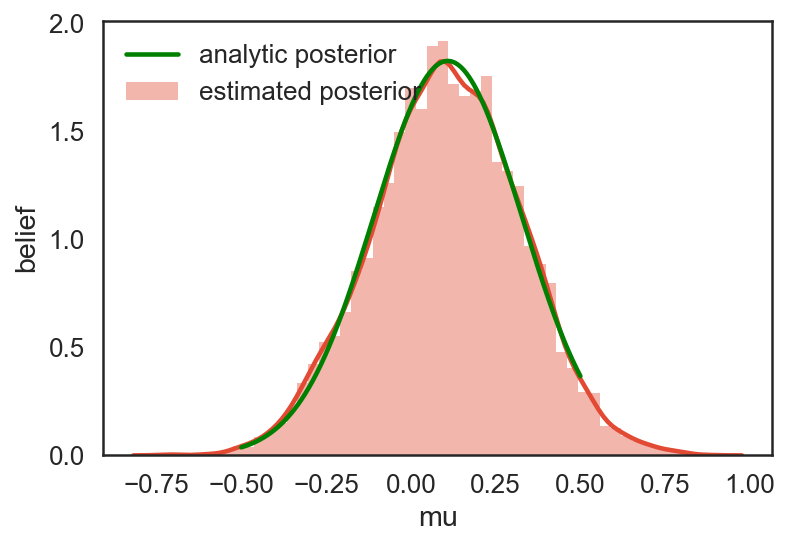

In [50]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();